In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import astropy.constants as const
import astropy.units as u
from astropy.coordinates import SkyCoord
import healpy as hp
import os
import sys
sys.path.insert(0, '/home/aew492/lss-dipoles')
import tools
from dipole import dipole_map

In [3]:
def EllisBaldwin(x, alpha, v=369.825*u.km/u.s):
    """
    Returns the expected dipole amplitude from Ellis & Baldwin (1984), given
        x = number-count slope at flux density limit
        alpha = source spectral index assuming power law spectra
    """
    return v / const.c.to(u.km/u.s) * (2 + x * (1+alpha))

In [4]:
def get_dipole(amps):
    amp = np.linalg.norm(amps[1:]/amps[0])
    direction = hp.vec2dir(amps[1:])
    direction = SkyCoord(direction[1], np.pi/2 - direction[0], frame='icrs', unit='rad').galactic
    # print(f"amp = {amp:.6f}")
    # print("direction: ", direction)
    return amp, direction

**GOAL:** Replicate the results from Secrest et al. (2021) and confirm that my dipole fitting function matches.

#### load S21 CatWISE2020

In [5]:
tab_S21 = Table.read(
    '/scratch/aew492/quasars/catalogs/Secrest/catwise_agns_masked_final_w1lt16p5_alpha.fits', format='fits')

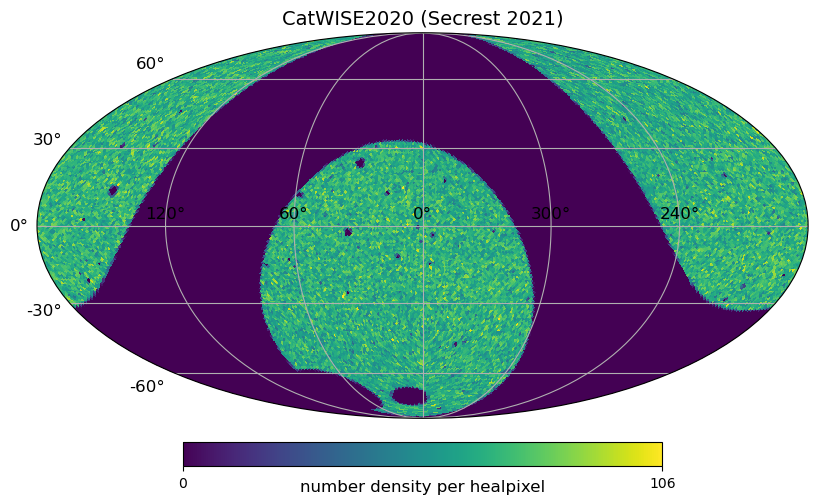

In [6]:
map_S21 = tools.load_catalog_as_map(tab_S21, frame='icrs')
tools.plot_map(map_S21, title='CatWISE2020 (Secrest 2021)', unit='number density per healpixel')

### spectral index $\alpha$ distribution

$$
\alpha = -\frac{d\log S_\nu}{d\log\nu}
$$

#### magnitudes $\mathrm{W}1-\mathrm{W}2$

WISE magnitudes are in the Vega system, so we need to convert to AB:

In [7]:
def Vega_to_AB(w1w2_Vega, offset=-0.640):  # offset computed from WISE photometric zero points
                            #  (Table 3 in https://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec4_4h.html)
    return w1w2_Vega + offset

In [8]:
def compute_alpha(W1, W2, lambda_W1=3.3526, lambda_W2=4.6028):
    """
    Compute the spectral slope alpha for a source with given BP and RP magnitudes.
    PARAMETERS:
    - W1 = magnitude in W1 band (Vega system)
    - W2 = magnitude in W2 band (Vega system)
    - lambda_W1 = isophotal wavelength (microns) of W1 passband
    - lambda_R = isophotal wavelength (microns) of W2 passband
    """
    # convert given (W1-W2)_Vega to AB color (W1-W2)_AB
    W1W2_AB = Vega_to_AB(W1-W2)
    
    alpha = W1W2_AB/(2.5*np.log10(lambda_W2/lambda_W1))

    return alpha

Secrest makes a magnitude cut $9>\mathrm{W}1>16.4$ (Vega).

In [9]:
# magnitudes
mag_cut = (tab_S21['w1']<=16.4)
w1_ = tab_S21['w1'][mag_cut]
w2_ = tab_S21['w2'][mag_cut]

In [10]:
alphas = [compute_alpha(w1_[i], w2_[i]) for i in range(len(w1_))]

Text(0.5, 1.0, 'S21 spectral slopes ($\\alpha$)')

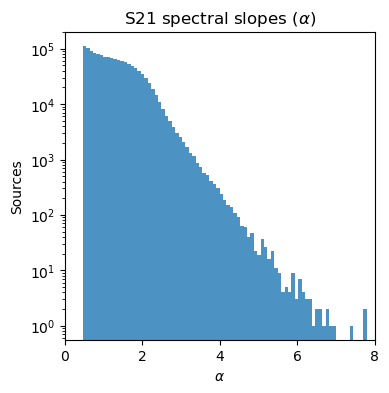

In [11]:
# plot distribution
fig, ax = plt.subplots(figsize=(4,4))

n, bins, _ = ax.hist(alphas, bins=120, alpha=0.8)
ax.set_xlim((0,8))  # to match plot in S21
ax.set_yscale('log')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel('Sources')
ax.set_title(r'S21 spectral slopes ($\alpha$)')

In [34]:
min(alphas), np.mean(alphas), np.median(alphas)

(0.46498067339046123, 1.2570238304804777, 1.1595549691463516)

According to S21 the mean is 1.26 !

I should note that I use the isophotal wavelengths published by WISE (Table 9) but S21 seems to calculate the isophotal wavelengths by hand (Eq. A19 in Bessel & Murphy 2012).

### number-count slope $x$

$$
x\equiv -\left.\frac{d\ln N(>S_\nu)}{d\ln S_\nu}\right|_{S_\mathrm{min}}
$$

We'll estimate the number-count slope at W1=16.4 as $(x_{16.5}-x_{16.3})0.2$

In [13]:
w1 = tab_S21['w1']

Text(0.5, 1.0, 'S21 W1 magnitudes')

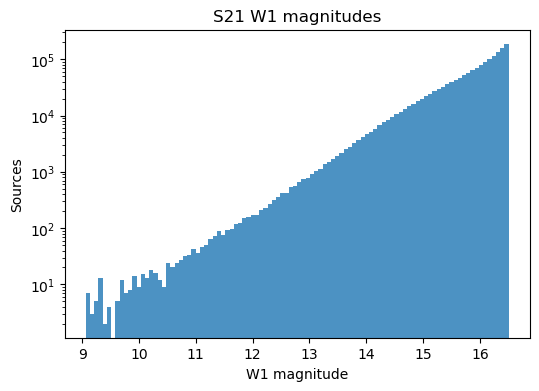

In [14]:
fig, ax = plt.subplots(figsize=(6,4))
_, _, _ = ax.hist(w1, bins=100, alpha=0.8)
ax.set_yscale('log')
ax.set_xlabel('W1 magnitude')
ax.set_ylabel('Sources')
ax.set_title('S21 W1 magnitudes')

In [15]:
max(w1), np.sum(w1>16.4)/len(tab_S21)

(16.50094722830057, 0.15522391036604521)

In [16]:
# count the number of sources in bins of magnitude
width = 0.1
min_w1 = 14
max_w1 = 16.5
nmags = int((max_w1-min_w1)/width)+1
mags = np.linspace(min_w1, max_w1, nmags)
counts = np.array([np.sum(w1<=mag) for mag in mags])

Text(0.5, 1.0, 'S21 W1 number counts')

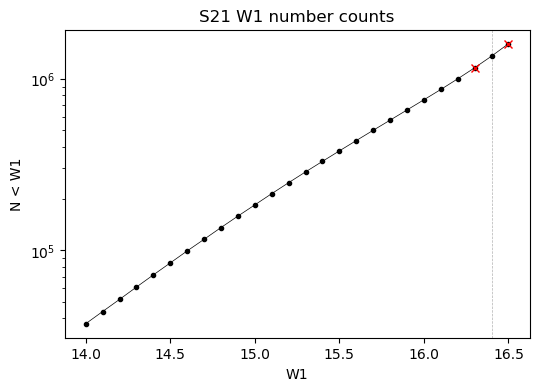

In [17]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(mags, counts, 'k.-', lw=0.5)
ax.axvline(16.4, color='k', alpha=0.3, ls='--', lw=0.5)
ax.plot(mags[-1], counts[-1], marker='x', color='r')
ax.plot(mags[-3], counts[-3], marker='x', color='r')

ax.set_yscale('log')
ax.set_xlabel('W1')
ax.set_ylabel('N < W1')
ax.set_title('S21 W1 number counts')

In [18]:
# slope of interest:
dlogN = np.log10(counts[-1]) - np.log10(counts[-3])
dmags = mags[-1] - mags[-3]
x = 2.5 * dlogN / dmags
x

1.755116940618679

### expected dipole

In [19]:
EllisBaldwin(x, np.mean(alphas))

<Quantity 0.00735393>

S21 lists 0.007 as the expected dipole from the CMB

### healpy fit

In [20]:
# prepare map
map_S21_tofit = np.copy(map_S21).astype(float)
idx_zero = (map_S21==0.)
map_S21_tofit[idx_zero] = hp.UNSEEN
map_nodip, monopole, dipole = hp.pixelfunc.remove_dipole(map_S21_tofit, fitval=True)

In [21]:
dipole/monopole

array([-0.01203086,  0.00780072,  0.00137645])

In [22]:
get_dipole(np.append(monopole, dipole))

(0.014404421989149303,
 <SkyCoord (Galactic): (l, b) in deg
     (230.88440895, 41.37588042)>)

S21 finds $\mathcal{D}=0.01554$ towards $(l,b)=(238.2^\circ,28.8^\circ)$

**Note!! I haven't corrected for the "mild inverse linear trend in source density versus absolute ecliptic latitude"**

### check my dipole fit

In [23]:
# 3 orthogonal dipole templates
template_amps = np.column_stack((np.zeros(3), np.diag(np.ones(3))))  # first column for the monopole
template_maps = np.array([dipole_map(amps) for amps in template_amps])

In [24]:
# design matrix
A = np.column_stack((np.ones(len(map_S21)), template_maps.T))
# covariances: identity for now
Cinv = np.ones(len(map_S21))

In [25]:
# perform the regression
bestfit_pars, bestfit_Cinv = tools.lstsq(map_S21[~idx_zero], A[~idx_zero], Cinv[~idx_zero])

In [26]:
bestfit_pars/bestfit_pars[0]

array([ 1.        , -0.01203086,  0.00780072,  0.00137645])

In [27]:
get_dipole(bestfit_pars)

(0.014404421989151282,
 <SkyCoord (Galactic): (l, b) in deg
     (230.88440895, 41.37588042)>)

Okay my least-squares fit matches `healpy.fit_dipole` !

### test more conservative cuts

In [28]:
# S21 makes an absolute galactic latitude cut at 30 deg
np.amin(np.abs(tab_S21['b']))

30.000039114580716

In [29]:
blims = [35, 40, 45, 50, 55, 60]

In [30]:
def mean_alpha(table, mag_lim=16.4):
    mag_cut = (table['w1'] <= mag_lim)
    w1_ = table['w1'][mag_cut]
    w2_ = table['w2'][mag_cut]
    alphas = [compute_alpha(w1_[i], w2_[i]) for i in range(len(w1_))]
    return np.mean(alphas)

In [31]:
def numbercount_slope(table, width=0.1, min_w1=16., max_w1=16.5):
    nmags = int((max_w1-min_w1)/width)+1
    mags = np.linspace(min_w1, max_w1, nmags)
    counts = np.array([np.sum(table['w1'] <= mag) for mag in mags])
    # slope of interest:
    dlogN = np.log10(counts[-1]) - np.log10(counts[-3])
    dmags = mags[-1] - mags[-3]
    return 2.5 * dlogN / dmags

In [32]:
# Ellis-Baldwin approximation
EB_approxs = np.empty(len(blims))
for i, blim in enumerate(blims):
    tab_bcut = tab_S21[np.abs(tab_S21['b']) < blim]
    EB_approx = EllisBaldwin(numbercount_slope(tab_bcut), mean_alpha(tab_bcut))
    print(f'|b|<{blim}deg: {EB_approx:.6f}')
    EB_approxs[i] = EB_approx

|b|<35deg: 0.007342
|b|<40deg: 0.007335
|b|<45deg: 0.007339
|b|<50deg: 0.007346
|b|<55deg: 0.007357
|b|<60deg: 0.007352


|b|<35deg:
	amp = 0.012582
	direction: <SkyCoord (Galactic): (l, b) in deg
    (229.3916561, 46.1424694)> 
	ratio to expectation = 1.714
|b|<40deg:
	amp = 0.010678
	direction: <SkyCoord (Galactic): (l, b) in deg
    (213.07330066, 56.09617029)> 
	ratio to expectation = 1.456
|b|<45deg:
	amp = 0.011840
	direction: <SkyCoord (Galactic): (l, b) in deg
    (235.23228376, 44.86266693)> 
	ratio to expectation = 1.613
|b|<50deg:
	amp = 0.015320
	direction: <SkyCoord (Galactic): (l, b) in deg
    (252.8824785, 29.60317096)> 
	ratio to expectation = 2.086
|b|<55deg:
	amp = 0.012817
	direction: <SkyCoord (Galactic): (l, b) in deg
    (247.18563506, 37.87760193)> 
	ratio to expectation = 1.742
|b|<60deg:
	amp = 0.016133
	direction: <SkyCoord (Galactic): (l, b) in deg
    (262.08914672, 24.11170555)> 
	ratio to expectation = 2.194


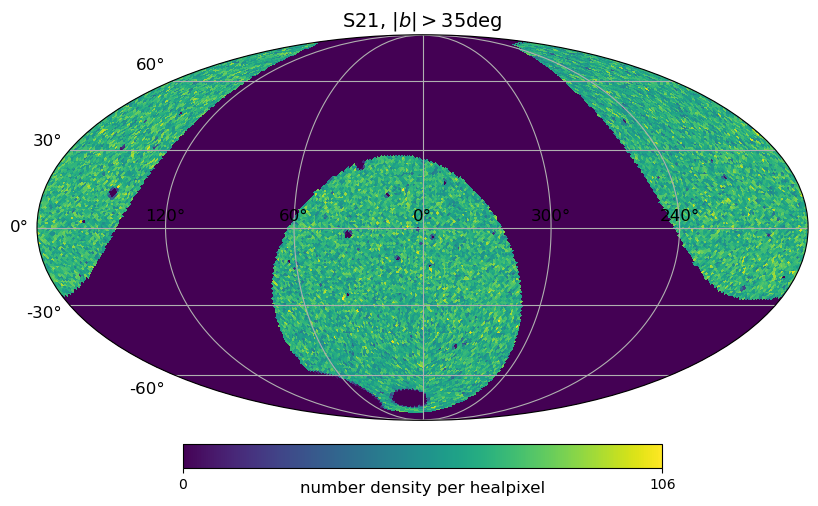

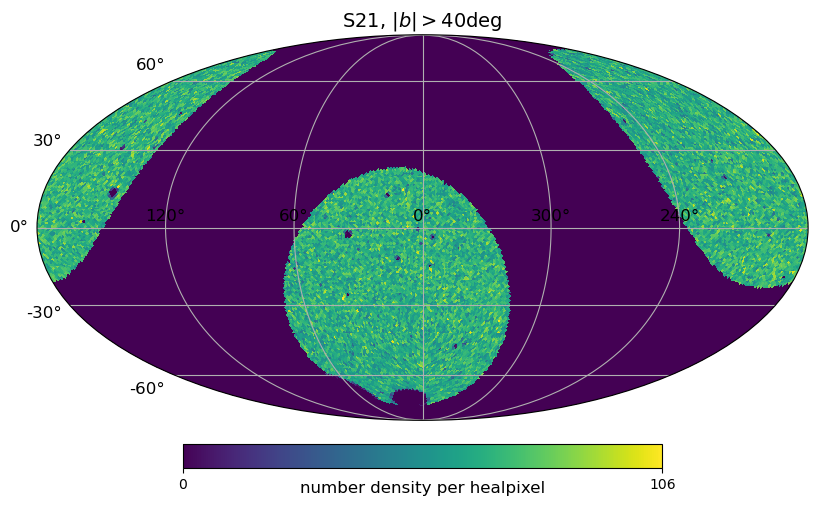

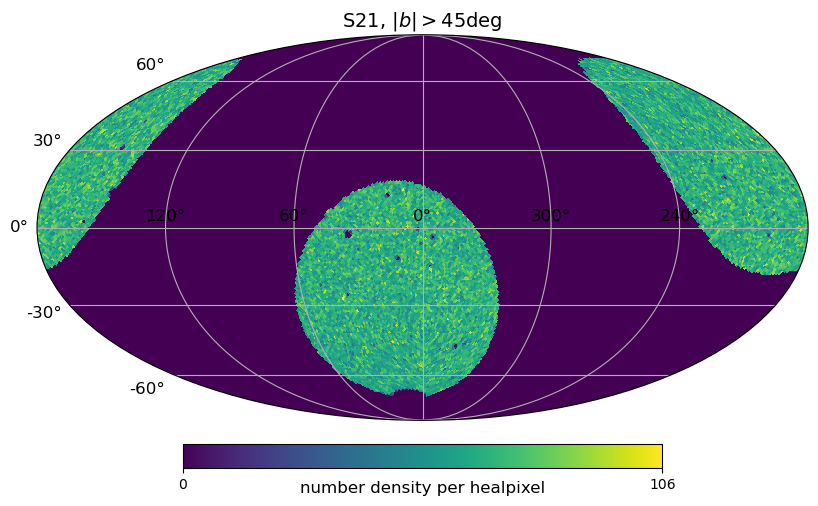

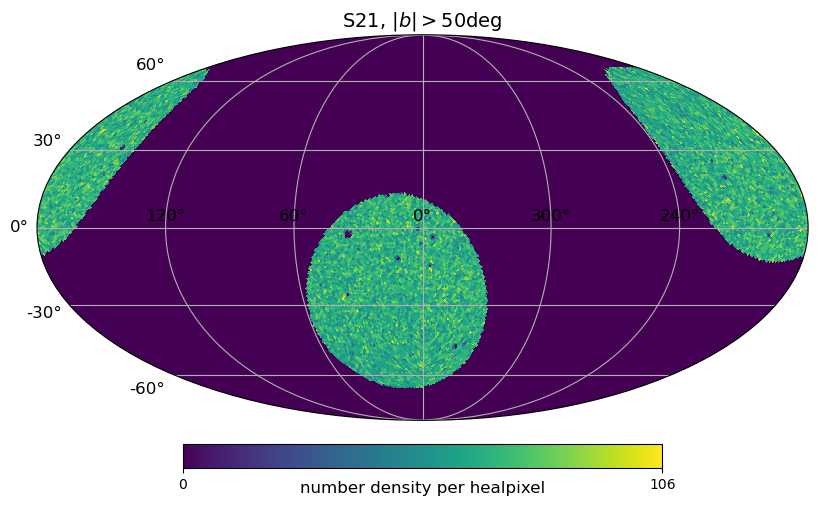

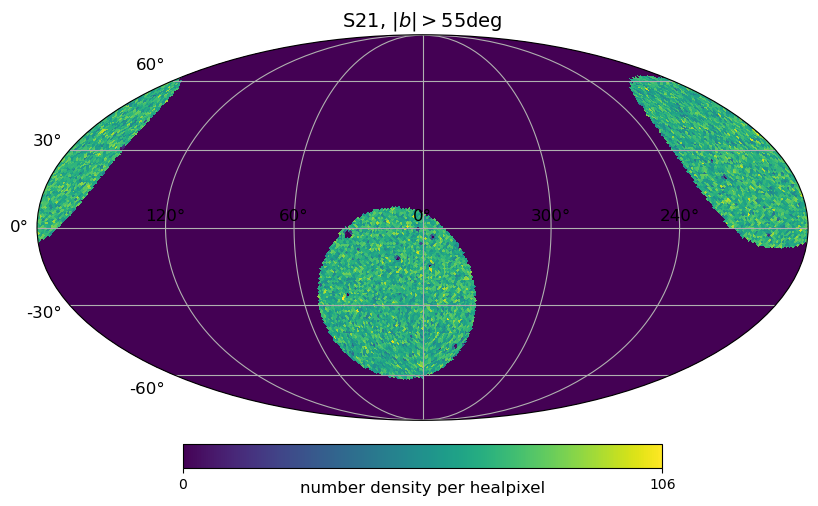

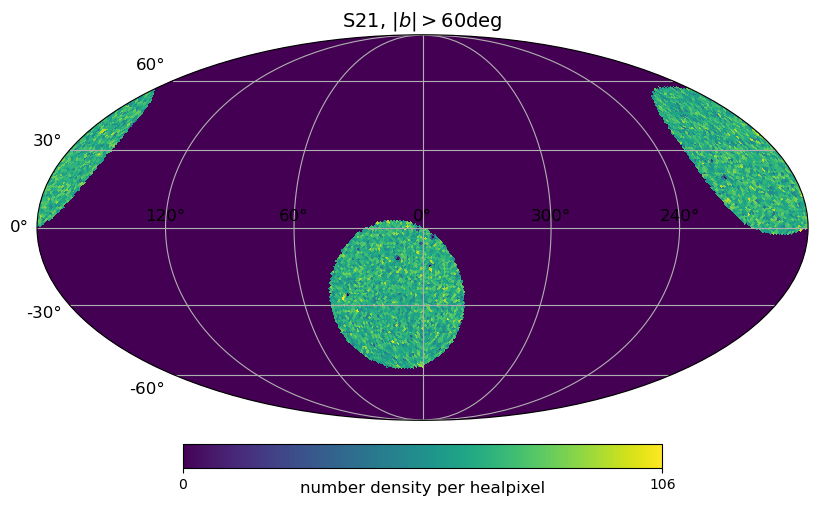

In [33]:
# linear fit
for i, blim in enumerate(blims):
    print(f'|b|<{blim}deg:')
    map_bcut = map_S21 * tools.get_galactic_mask(blim, frame='icrs')
    tools.plot_map(map_bcut, title='S21, $|b|>$'+f'{blim}deg', unit='number density per healpixel')
    idx_zero = (map_bcut==0.)
    bestfit_pars_bcut, bestfit_Cinv_bcut = tools.lstsq(map_bcut[~idx_zero], A[~idx_zero], Cinv[~idx_zero])
    dipole_amp, dipole_dir = get_dipole(bestfit_pars_bcut)
    print(f'\tamp = {dipole_amp:.6f}\n\tdirection:', dipole_dir, \
          f'\n\tratio to expectation = {dipole_amp / EB_approxs[i]:.3f}')